In [118]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
from sklearn.impute import KNNImputer
import seaborn as sns
from scipy.io import arff
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [119]:
data = []
with open('data/chronic_kidney_disease_full.arff', "r") as f:
    for line in f:
        line = line.replace('\n', '')
        line = line.replace('\t', '')
        data.append(line.split(','))

names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
         'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc',
         'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
         'class']

df = pd.DataFrame(data[145:], columns=names)
for c in df.columns:
    df.loc[df[c] == '?', c] = np.nan
df.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [120]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      151
pc        65
pcc        4
ba         4
bgr       43
bu        19
sc        17
sod       85
pot       86
hemo      52
pcv       71
wbcc     106
rbcc     129
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

### encode the data

In [121]:
cat_feat = ["rbc","pc","pcc","ba","htn","dm","cad","appet","pe","ane","class"]
num_feat = {var: df[var] for var in df if var not in cat_feat}
for var in ["rbc","pc","pcc","ba","htn","dm","cad","appet","pe","ane","class"]:
    df[var].fillna(df[var].mode()[0],inplace=True)
for var in num_feat:
    df[var].fillna(df[var].median(),inplace=True)
num_feat

{'age': 0      48
 1      51
 2      60
 3      68
 4      24
        ..
 392    55
 393    42
 394    12
 395    17
 396    58
 Name: age, Length: 397, dtype: object,
 'bp': 0        80
 1        80
 2        90
 3        70
 4      80.0
        ... 
 392      80
 393      70
 394      80
 395      60
 396      80
 Name: bp, Length: 397, dtype: object,
 'sg': 0      1.020
 1      1.010
 2      1.015
 3      1.010
 4      1.015
        ...  
 392    1.020
 393    1.025
 394    1.020
 395    1.025
 396    1.025
 Name: sg, Length: 397, dtype: object,
 'al': 0      1
 1      2
 2      3
 3      0
 4      2
       ..
 392    0
 393    0
 394    0
 395    0
 396    0
 Name: al, Length: 397, dtype: object,
 'su': 0      0
 1      0
 2      0
 3      0
 4      4
       ..
 392    0
 393    0
 394    0
 395    0
 396    0
 Name: su, Length: 397, dtype: object,
 'bgr': 0      121
 1      106
 2       74
 3      100
 4      410
       ... 
 392    140
 393     75
 394    100
 395    114
 396    

In [122]:
df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,normal,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd
2,60,90,1.015,3,0,normal,normal,notpresent,notpresent,74,...,39,7800,4.4,yes,yes,no,good,yes,no,ckd
3,68,70,1.010,0,0,normal,normal,notpresent,notpresent,100,...,36,8100.0,4.8,no,no,no,good,no,no,ckd
4,24,80.0,1.015,2,4,normal,abnormal,notpresent,notpresent,410,...,44,6900,5,no,yes,no,good,yes,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,55,80,1.020,0,0,normal,normal,notpresent,notpresent,140,...,47,6700,4.9,no,no,no,good,no,no,notckd
393,42,70,1.025,0,0,normal,normal,notpresent,notpresent,75,...,54,7800,6.2,no,no,no,good,no,no,notckd
394,12,80,1.020,0,0,normal,normal,notpresent,notpresent,100,...,49,6600,5.4,no,no,no,good,no,no,notckd
395,17,60,1.025,0,0,normal,normal,notpresent,notpresent,114,...,51,7200,5.9,no,no,no,good,no,no,notckd


In [123]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
df[cat_feat] = df[cat_feat].apply(le.fit_transform)
df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,1,1,0,0,121,...,44,7800,5.2,1,1,0,0,0,0,0
1,51,80,1.010,2,0,1,1,0,0,106,...,35,7300,4.6,0,0,0,0,0,0,0
2,60,90,1.015,3,0,1,1,0,0,74,...,39,7800,4.4,1,1,0,0,1,0,0
3,68,70,1.010,0,0,1,1,0,0,100,...,36,8100.0,4.8,0,0,0,0,0,0,0
4,24,80.0,1.015,2,4,1,0,0,0,410,...,44,6900,5,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,55,80,1.020,0,0,1,1,0,0,140,...,47,6700,4.9,0,0,0,0,0,0,1
393,42,70,1.025,0,0,1,1,0,0,75,...,54,7800,6.2,0,0,0,0,0,0,1
394,12,80,1.020,0,0,1,1,0,0,100,...,49,6600,5.4,0,0,0,0,0,0,1
395,17,60,1.025,0,0,1,1,0,0,114,...,51,7200,5.9,0,0,0,0,0,0,1


In [124]:
for var in num_feat:
    df[var] = pd.to_numeric(df[var])
df.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc        int32
pc         int32
pcc        int32
ba         int32
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn        int32
dm         int32
cad        int32
appet      int32
pe         int32
ane        int32
class      int32
dtype: object

age        AxesSubplot(0.125,0.749828;0.133621x0.130172)
bp      AxesSubplot(0.285345,0.749828;0.133621x0.130172)
sg       AxesSubplot(0.44569,0.749828;0.133621x0.130172)
al      AxesSubplot(0.606034,0.749828;0.133621x0.130172)
su      AxesSubplot(0.766379,0.749828;0.133621x0.130172)
bgr        AxesSubplot(0.125,0.593621;0.133621x0.130172)
bu      AxesSubplot(0.285345,0.593621;0.133621x0.130172)
sc       AxesSubplot(0.44569,0.593621;0.133621x0.130172)
sod     AxesSubplot(0.606034,0.593621;0.133621x0.130172)
pot     AxesSubplot(0.766379,0.593621;0.133621x0.130172)
hemo       AxesSubplot(0.125,0.437414;0.133621x0.130172)
pcv     AxesSubplot(0.285345,0.437414;0.133621x0.130172)
wbcc     AxesSubplot(0.44569,0.437414;0.133621x0.130172)
rbcc    AxesSubplot(0.606034,0.437414;0.133621x0.130172)
dtype: object

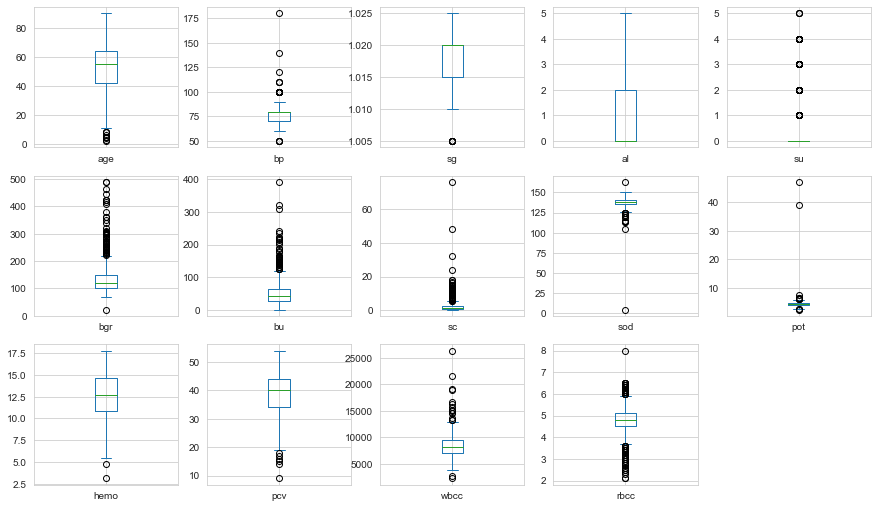

In [125]:
listToRemove = ["rbc", "pc", "pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane", "class"]
columnsName = df.columns
for var in listToRemove:
    columnsName = columnsName.drop(var)
plt.Figure(figsize=(10, 6))
df1=df.copy()
df1.drop(columns=listToRemove).plot(kind='box', subplots=True, layout=(5, 5), figsize=(15, 15))

In [126]:
outliers_bound_L = dict()
outliers_bound_U = dict()
ratio = dict()
ratioU = dict()
ratioL= dict()
important_feature_modified = columnsName.copy()
listU = []
listL = []
for val in important_feature_modified:
    price = df[val].describe()
    outliers_bound_U[val] = price.loc["75%"] + 1.5 * (price.loc["75%"] - price.loc["25%"])
    outliers_bound_L[val] = price.loc["25%"] - 1.5 * (price.loc["75%"] - price.loc["25%"])
    ratio[val] = (len(df[df[val] > outliers_bound_U[val]]) + len(df[df[val] < outliers_bound_L[val]]) / len(df[val]))
    ratioU[val] = (len(df[df[val] > outliers_bound_U[val]]) / len(df[val]))
    ratioL[val] = (len(df[df[val] < outliers_bound_L[val]]) / len(df[val]))

print(outliers_bound_L, outliers_bound_U, ratio, sep="\n")

{'age': 9.0, 'bp': 55.0, 'sg': 1.0074999999999998, 'al': -3.0, 'su': 0.0, 'bgr': 27.5, 'bu': -28.5, 'sc': -1.8000000000000003, 'sod': 126.0, 'pot': 2.8000000000000003, 'hemo': 5.200000000000002, 'pcv': 19.0, 'wbcc': 3400.0, 'rbcc': 3.6000000000000005}
{'age': 97.0, 'bp': 95.0, 'sg': 1.0275000000000003, 'al': 5.0, 'su': 0.0, 'bgr': 223.5, 'bu': 119.5, 'sc': 5.4, 'sod': 150.0, 'pot': 6.0, 'hemo': 20.4, 'pcv': 59.0, 'wbcc': 13000.0, 'rbcc': 5.999999999999999}
{'age': 0.022670025188916875, 'bp': 31.01007556675063, 'sg': 0.015113350125944584, 'al': 0.0, 'su': 60.0, 'bgr': 51.00251889168766, 'bu': 38.0, 'sc': 53.0, 'sod': 1.0403022670025188, 'pot': 10.007556675062972, 'hemo': 0.005037783375314861, 'pcv': 0.015113350125944584, 'wbcc': 15.005037783375315, 'rbcc': 32.10831234256927}


In [127]:
for var in ratioU:
    if ratioU[var] > 0:
        listU.append(var)
for var in ratioL:
    if ratioL[var] !=0:
        listL.append(var)
print("lower : "+str(listL) + " upper : " +str(listU) )

lower : ['age', 'bp', 'sg', 'bgr', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc'] upper : ['bp', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'wbcc', 'rbcc']


In [128]:
for val in listU:
    df.loc[df[val] > outliers_bound_U[val], val] = df[val].median()
for val in listL:
    df.loc[df[val] < outliers_bound_L[val], val] = df[val].median()
df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.0,...,44.0,7800.0,5.2,1,1,0,0,0,0,0
1,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.0,...,35.0,7300.0,4.6,0,0,0,0,0,0,0
2,60.0,90.0,1.015,3.0,0.0,1,1,0,0,74.0,...,39.0,7800.0,4.4,1,1,0,0,1,0,0
3,68.0,70.0,1.010,0.0,0.0,1,1,0,0,100.0,...,36.0,8100.0,4.8,0,0,0,0,0,0,0
4,24.0,80.0,1.015,2.0,0.0,1,0,0,0,121.0,...,44.0,6900.0,5.0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.0,...,47.0,6700.0,4.9,0,0,0,0,0,0,1
393,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.0,...,54.0,7800.0,4.8,0,0,0,0,0,0,1
394,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.0,...,49.0,6600.0,5.4,0,0,0,0,0,0,1
395,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.0,...,51.0,7200.0,5.9,0,0,0,0,0,0,1


In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
kf=KFold(n_splits=10 , random_state=10, shuffle=True)
newdd = df.drop(columns=['su'])
X = df.drop(columns=['class'])
y = df['class']
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
# X_train, X_test, y_train, y_test = kf.split(X, y)
scores = []
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((277, 24), (277,), (120, 24), (120,))

In [130]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
# tmp=df["class"].copy()
X_train_N=sc.fit_transform(X_train)
X_test_N=sc.fit_transform(X_test)

X_train_df=pd.DataFrame(X_train_N, columns=X_train.columns)
X_test_df=pd.DataFrame(X_test_N, columns=X_test.columns)


In [131]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
num_cols=["age", "bp", "sg", "al", "bgr", "bu", "sc", "sod", "pot", "hemo", "pcv", "wbcc", "rbcc"]
# tmp=df["class"].copy()
X[num_cols]=sc.fit_transform(X[num_cols])
X
# X=pd.DataFrame(X_train_N, columns=X_train.columns)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,-0.311847,0.538663,0.390202,0.091306,0.0,1,1,0,0,0.002341,...,1.055005,0.593025,-0.138824,0.919490,1,1,0,0,0,0
1,-0.116162,0.538663,-1.546176,0.862547,0.0,1,1,0,0,-0.495565,...,-0.380403,-0.594022,-0.423205,-0.477338,0,0,0,0,0,0
2,0.470892,1.607909,-0.577987,1.633789,0.0,1,1,0,0,-1.557764,...,-0.153760,-0.066445,-0.138824,-0.942947,1,1,0,0,1,0
3,0.992719,-0.530583,-1.546176,-0.679936,0.0,1,1,0,0,-0.694727,...,-0.078212,-0.462128,0.031805,-0.011728,0,0,0,0,0,0
4,-1.877326,0.538663,-0.577987,0.862547,0.0,1,0,0,0,0.002341,...,-0.078212,0.593025,-0.650710,0.453881,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.144751,0.538663,0.390202,-0.679936,0.0,1,1,0,0,0.633022,...,1.168326,0.988708,-0.764462,0.221076,0,0,0,0,0,0
393,-0.703217,-0.530583,1.358391,-0.679936,0.0,1,1,0,0,-1.524570,...,1.470518,1.911967,-0.138824,-0.011728,0,0,0,0,0,0
394,-2.660065,0.538663,0.390202,-0.679936,0.0,1,1,0,0,-0.694727,...,1.206100,1.252496,-0.821339,1.385100,0,0,0,0,0,0
395,-2.333924,-1.599829,1.358391,-0.679936,0.0,1,1,0,0,-0.230015,...,0.601718,1.516285,-0.480081,2.549123,0,0,0,0,0,0


<AxesSubplot:>

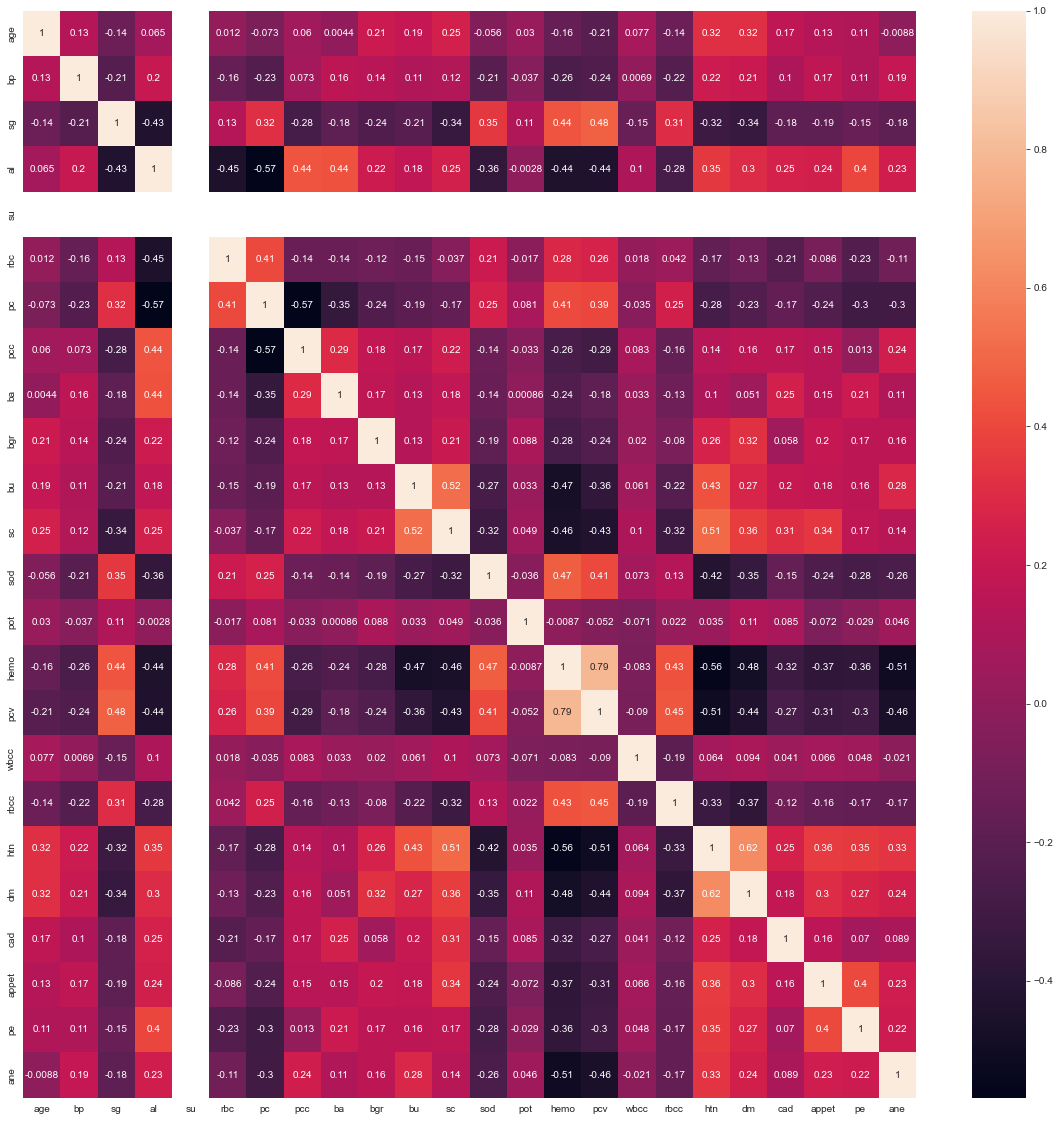

In [132]:
# Visualize Correlated Features
corr = X_train_df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
sns.heatmap(corr,annot=True)

In [133]:
# Brute Force Method to find Correlation between features
def correlation(data, threshold=None):
    # Set of all names of correlated columns
    col_corr = set()
    corr_mat = data.corr()
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if (abs(corr_mat.iloc[i,j]) >= threshold):
                colname = corr_mat.columns[i]
                col_corr.add(colname)
    return col_corr

In [134]:
correlated_features = correlation(data=X_train, threshold=0.5)
print (len(set(correlated_features)))
print (set(correlated_features))

7
{'sc', 'ane', 'pc', 'dm', 'pcc', 'htn', 'pcv'}


In [135]:
corr = X_train.corrwith(y)
abs(corr)<0.5

age       True
bp        True
sg       False
al       False
su       False
rbc       True
pc        True
pcc       True
ba        True
bgr       True
bu        True
sc       False
sod      False
pot       True
hemo     False
pcv      False
wbcc      True
rbcc      True
htn      False
dm       False
cad       True
appet     True
pe        True
ane       True
dtype: bool

In [136]:
X_train_cor1 = X_train.drop(columns=correlated_features)
X_test_cor1 = X_test.drop(columns=correlated_features)

In [137]:
corr = X_train_cor1.corr()
correlated_features1 = correlation(data=X_train_cor1, threshold=0.5)
print (len(set(correlated_features1)))
print (set(correlated_features1))

0
set()


## Using the Formula

In [138]:
import CFS
idx = CFS.cfs(X.to_numpy(), y.to_numpy())
print(idx)

[18  2 19  3 21 15  6 23 22 17  5  1 20]


In [139]:
list_to_keep = X_train_df.columns[idx]

In [140]:
list_to_keep

Index(['htn', 'sg', 'dm', 'al', 'appet', 'pcv', 'pc', 'ane', 'pe', 'rbcc',
       'rbc', 'bp', 'cad'],
      dtype='object')

In [141]:
list_to_drop = {var: X_train[var] for var in X_train if var not in list_to_keep}


In [142]:
X_train_cor2 = X_train.drop(columns=list_to_drop)
X_test_cor2 = X_test.drop(columns=list_to_drop)
X_cfs=X.drop(columns=list_to_drop)
X_cfs

,bp,sg,al,rbc,pc,pcv,rbcc,htn,dm,cad,appet,pe,ane
0,0.538663,0.390202,0.091306,1,1,0.593025,0.919490,1,1,0,0,0,0
1,0.538663,-1.546176,0.862547,1,1,-0.594022,-0.477338,0,0,0,0,0,0
2,1.607909,-0.577987,1.633789,1,1,-0.066445,-0.942947,1,1,0,0,1,0
3,-0.530583,-1.546176,-0.679936,1,1,-0.462128,-0.011728,0,0,0,0,0,0
4,0.538663,-0.577987,0.862547,1,0,0.593025,0.453881,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.538663,0.390202,-0.679936,1,1,0.988708,0.221076,0,0,0,0,0,0
393,-0.530583,1.358391,-0.679936,1,1,1.911967,-0.011728,0,0,0,0,0,0
394,0.538663,0.390202,-0.679936,1,1,1.252496,1.385100,0,0,0,0,0,0
395,-1.599829,1.358391,-0.679936,1,1,1.516285,2.549123,0,0,0,0,0,0


## KNN classifier

In [143]:
def show_score(y_pred_NB_bf):
    acc=accuracy_score(y_test, y_pred_NB_bf)
    f1=f1_score(y_test, y_pred_NB_bf)
    pre=precision_score(y_test, y_pred_NB_bf)
    recall=recall_score(y_test, y_pred_NB_bf)
    print("the  accuracy score of  model is %.3f" % acc)
    print("the  f-score score of  model is %.3f" % f1)
    print("the  precision score of  model is %.3f" % pre)
    print("the  recall score of model is %.3f" % recall)
    return [acc, f1, pre, recall]

def show_score_kfold(model, x):
    acc=np.mean(cross_val_score(model, x,y, cv=kf, n_jobs=-1, scoring="accuracy"))
    f1=np.mean(cross_val_score(model, x,y, cv=kf, n_jobs=-1, scoring="f1"))
    pre=np.mean(cross_val_score(model, x,y, cv=kf, n_jobs=-1, scoring="precision"))
    recall=np.mean(cross_val_score(model, x,y, cv=kf, n_jobs=-1, scoring="recall"))
    print("accuracy %.5f"%acc)
    print("f1-score %.5f"%f1)
    print("precision %.5f"%pre)
    print("recall %.5f"%recall)
    return [acc, f1, pre, recall]

In [144]:
#Import k-Nearest Neighbors
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
def k_score(X_train_cor1):
    score = []
    # Calculate score for k between 1 and 40

    for i in range(1, int(np.sqrt(X_train_cor1.shape[0]))+1):
        knn = KNeighborsClassifier(i, metric="euclidean")
        s=cross_val_score(knn, X, y, cv=kf, n_jobs=-1)
        score.append(np.mean(s))
    plt.figure(figsize=(12, 6))
    plt.plot(range(1,  int(np.sqrt(X.shape[0]))+1), score, color='red', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)
    plt.title('Score for each k value')
    plt.xlabel('K ')
    plt.ylabel('Score')

def k_elbow(X):
    distortions = []
    K = range(1,int(np.sqrt(X.shape[0]))+1)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(X)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

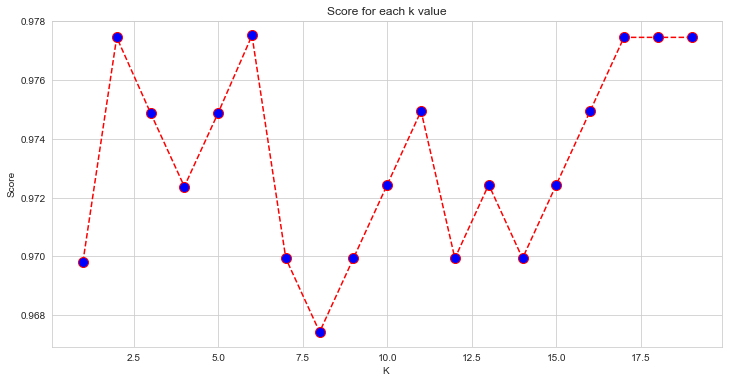

In [145]:
k_score(X)

C:\Users\anasb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\anasb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\anasb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\anasb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmea

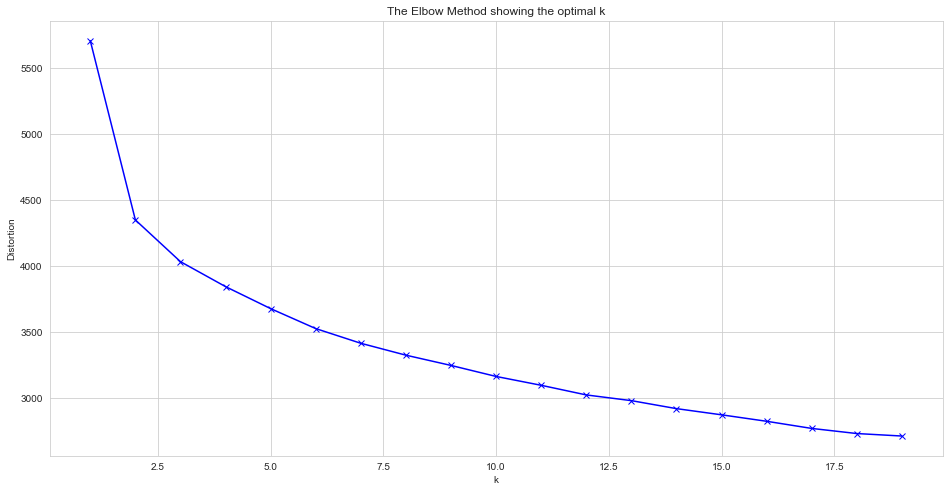

In [146]:
k_elbow(X)

In [147]:
#retrain the model with the best value k
knn = KNeighborsClassifier(13, metric="euclidean")
knn2 = KNeighborsClassifier(13, metric="euclidean")

# scores=[]

knn_bf_score=show_score_kfold(knn, X)
knn2.fit(X_train_cor2,y_train)

knn2.score(X_test_cor2,y_test)
# np.max(scores)

accuracy 0.97244
f1-score 0.96247
precision 0.94586
recall 0.98199


0.9666666666666667

## Knn + CFS

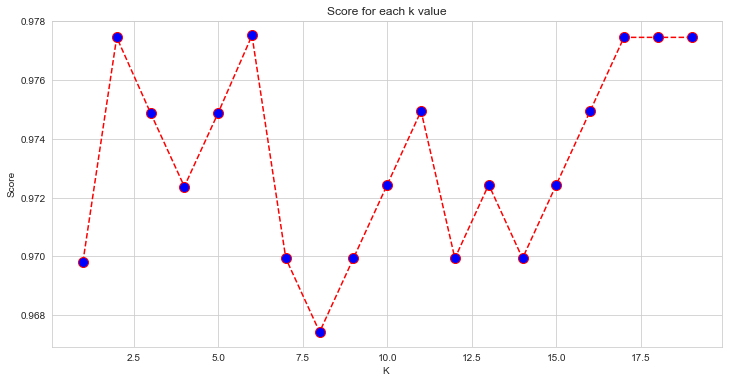

In [148]:
k_score(X_cfs)

C:\Users\anasb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\anasb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\anasb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\anasb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmea

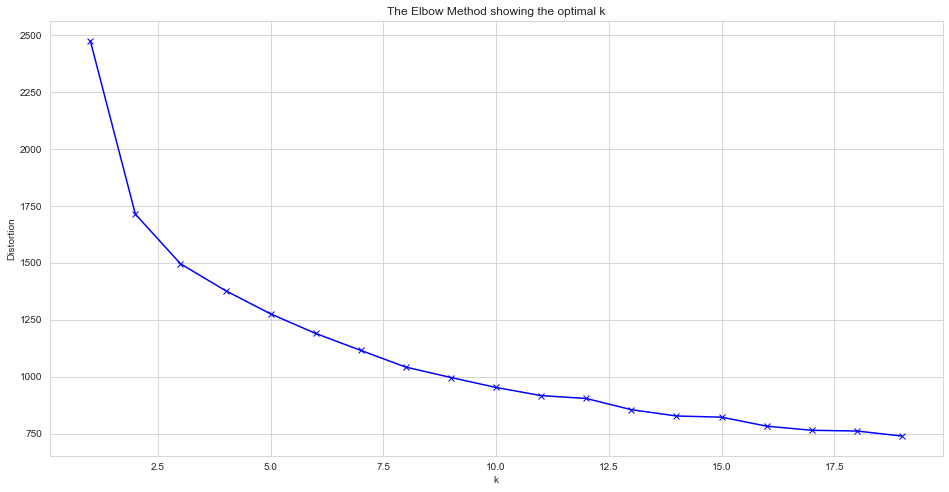

In [149]:
k_elbow(X_cfs)

In [150]:
knn = KNeighborsClassifier(13, metric="euclidean")
# scores=[]

knn_cfs_score=show_score_kfold(knn, X_cfs)

accuracy 0.94705
f1-score 0.93155
precision 0.87462
recall 1.00000


### knn + cfs+ bagging

In [151]:
from sklearn.ensemble import BaggingClassifier
knn_bagging=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=13, metric="euclidean"), n_estimators=500)
knn_ada_score=show_score_kfold(knn_bagging, X_cfs)

accuracy 0.94705
f1-score 0.92885
precision 0.87455
recall 1.00000


### SVM

In [152]:
#Import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
#train model

svm_bf_score=show_score_kfold(LinearSVC(), X)


accuracy 0.99250
f1-score 0.98697
precision 0.98412
recall 0.99000


## SVM + CFS

In [153]:
svm_cfs_score=show_score_kfold(LinearSVC(), X_cfs)

accuracy 0.98994
f1-score 0.98465
precision 0.97120
recall 1.00000


### SVM + CFS + Bagging

In [154]:

svm_bagging=BaggingClassifier(base_estimator=LinearSVC(), n_estimators=500)
svm_ada_score=show_score_kfold(svm_bagging, X_cfs)

accuracy 0.98737
f1-score 0.98143
precision 0.96495
recall 1.00000


## Naive Bayes

In [155]:
gnb=GaussianNB()
NB_bf_score=show_score_kfold(gnb, X)


accuracy 0.95474
f1-score 0.94298
precision 0.89557
recall 1.00000


## Naive Bayes + CFS

In [156]:

gnb=GaussianNB()

NB_cfs_score=show_score_kfold(gnb, X_cfs)


accuracy 0.95474
f1-score 0.94298
precision 0.89557
recall 1.00000


## Naive Bayes + CFS +Adaboost

In [157]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(base_estimator=GaussianNB(), n_estimators=500)
NB_ada_score=show_score_kfold(ada, X_cfs)

accuracy 0.95244
f1-score 0.92090
precision 0.95230
recall 0.91703


## display graphically the score results

In [158]:
def show_result_graph(s_knn, s_svm, s_nb,title):
    plt.plot(x,s_knn, "g-")
    plt.plot(x,s_svm, "b-")
    plt.plot(x,s_nb, "r-")
    plt.title(title)
    plt.show()

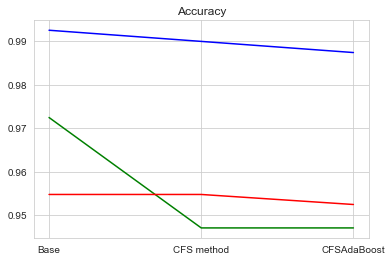

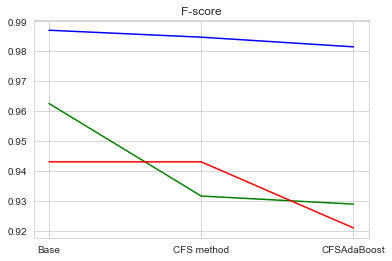

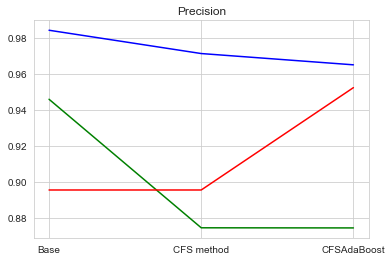

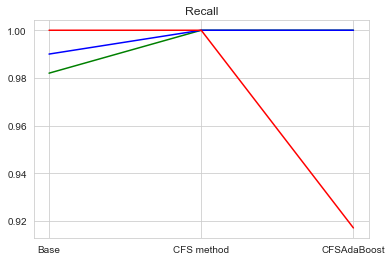

In [159]:
import matplotlib.pyplot as plt
x=["Base", "CFS method", "CFSAdaBoost"]

titles=["Accuracy", "F-score", "Precision", "Recall"]
for i in np.arange(4):
    s_knn=[knn_bf_score[i], knn_cfs_score[i], knn_ada_score[i]]
    s_svm=[svm_bf_score[i], svm_cfs_score[i], svm_ada_score[i]]
    s_nb=[NB_bf_score[i], NB_cfs_score[i], NB_ada_score[i]]
    show_result_graph(s_knn, s_svm, s_nb, titles[i])

